#  Trabajo práctico 3: Regularización aplicada a la EPH
### Grupo 8: Banfi, Catalina; Lima, Matías; López, Santiago. 

## Parte I: Análisis de la base de hogares y cálculo de pobreza

In [1]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm     

from sklearn import datasets
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, plot_roc_curve, average_precision_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

Lo primero que hacemos es crear un botón que permita esconder todas las celdas que sean código y mostrar todo lo demás si se lo desea. La solución no es original, sino que la obtuvimos de una provista por el usuario de Stack Overflow Eric Shepherd en el siguiente link: https://stackoverflow.com/a/53136940 

In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

También sumamos el siguiente código para ocultar las warnings, entendiendo que las mismas son útiles pero molestas en el caso de una presentación cuando ya se entendió el motivo de las mismas. Por este motivo, también dejamos comentada una línea que permite limitar la cantidad de advertencias por acción a 1. 

In [3]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

### 1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen que pueden ser muy predictivas de pobreza y que sería muy útil incluir para perfeccionar el ejercicio del TP2?

A priori, algunas de las variables que creemos que pueden ser útiles para predecir pobreza son: IV1 (tipo de vivienda), IV2 (habitaciones), IV8 (baño), IV12_3 (villa emergencia), II7 (régimen de tenencia) y V5 (ayuda social), así como naturalmente los ingresos totales familiares. 
Elegimos estas variables porque creemos que: a) pueden ser buenos predictores, y porque b) pueden ser relevantes por sí solas es decir, no elegimos variables que pueden llegar a superponer demasiado su poder explicativo potencial. El tipo de vivienda es una variable categórica que incluye casa, departamento, pieza de inquilinato, pieza en hotel o pensión y local no construido para habitación. Si bien no tiene un poder predictivo si es casa o departamento, las siguientes categorías sí claramente tienen un poder predictivo importante. IV2 identifica la cantidad de habitaciones, es lógico pensar que cuantas más habitaciones tenga un hogar, más grande es y por lo tanto más probable que sus integrantes tengan altos ingresos per cápita. IV8 especifica si el hogar tiene o baño o letrina, algo que también correlaciona con los ingresos. IV12_3 indica si el hogar se encuentra en una villa de emergencia, lo que es claramente un gran predictor de si el hogar es pobre o no. Yendo a las características habitacionales del hogar, el régimen de tenencia (II7) especifica si alguno de los habitantes del hogar es dueño de la vivienda y el terreno, si sólo de la vivienda, si es inquilino, ocupante gratuito con permiso o de hecho (sin permiso), entre otras categorías. Está claro que aquellos que son dueños es menos probable que sean pobres, mientras que lo contrario se da para ocupantes de hecho. Por último, V5 indica si en los últimos tres meses las personas del hogar han vivido de ayuda social del gobierno y/o otras instituciones. Quienes responden sí es más probable que estén en una situación de emergencia de ingresos o necesiten complementarlos. 

### 2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2022 (la base de hogares se llama usu_hogar_T122.xls). Importen los datos de la encuesta de hogar y al igual que en el TP1 conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [4]:
base_hogar = pd.read_excel("usu_hogar_T122.xlsx")
#base_hogar = pd.read_csv("usu_hogar_T122.csv", low_memory=False)

base_hogar_bs = base_hogar[(base_hogar['AGLOMERADO'] == 32) | (base_hogar['AGLOMERADO'] == 33)]

### 3. Unan la tabla de la encuesta individual con la de la encuesta de hogar.

In [5]:
base_individual = pd.read_excel("usu_individual_T122.xlsx")
#base_individual = pd.read_csv("usu_individual_T122.csv", low_memory=False)

base_individual_bs = base_individual[(base_individual['AGLOMERADO'] == 32) | (base_individual['AGLOMERADO'] == 33)]

In [6]:
base_merge = base_individual_bs.merge(base_hogar_bs, left_on=['CODUSU', 'NRO_HOGAR'], right_on=['CODUSU', 'NRO_HOGAR'], how='outer', suffixes=('', '_y'))

base_merge.drop(base_merge.filter(regex='_y$').columns, axis=1, inplace=True)

base_merge

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,1,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
1,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,2,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
2,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,3,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
3,TQRMNOPQQHKMRLCDEIJAH00780169,2022,1,1,1,1,1,S,33,456,...,2,1,0,1,1,0,98,0,0,0
4,TQRMNOSXRHJMTRCDEIJAH00693084,2022,1,1,1,1,1,S,33,1199,...,2,2,0,2,1,3,98,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701,TQRMNOTTSHKNLSCDEIIAD00780102,2022,1,1,2,1,1,S,32,2839,...,2,2,0,2,1,0,98,0,0,0
6702,TQRMNOPRPHMNMLCDEIIAD00701192,2022,1,1,1,1,1,S,32,2131,...,2,2,0,2,2,0,98,0,0,0
6703,TQRMNOPRPHMNMLCDEIIAD00701192,2022,1,1,2,1,1,S,32,2131,...,2,2,0,2,2,0,98,0,0,0
6704,TQRMNOSRWHKMLUCDEIIAD00780103,2022,1,1,1,1,1,S,32,1513,...,2,2,0,2,1,0,2,0,0,0


In [7]:
# Definimos las intersección entre las dos bases como una lista
columnas_duplicadas = set(base_hogar_bs.columns).intersection(set(base_individual_bs.columns))
# Removemos CODUSU y NRO_HOGAR de la lista ya que queremos usarlas para la intersección (y las columnas sobre las que se une
# no generan duplicados)
columnas_duplicadas.remove("CODUSU")
columnas_duplicadas.remove("NRO_HOGAR")

# Hacemos el merge habiendo dropeado las columnas repetidas
df5 = pd.merge(
    base_hogar_bs.drop(columnas_duplicadas, axis=1), 
    base_individual_bs,
    on= ['NRO_HOGAR', 'CODUSU']
)

### 4. Generen sus propias funciones para limpiar la base de datos o, si deciden utilizar funciones existentes en paquetes como numpy y pandas, mencionen cuáles usarán y de qué paquetes son.

Con el primer código lo que queremos es ver qué columnas tienen una gran cantidad de valores faltantes, para darnos una idea de cuál sería una cantidad justa para eliminar de la base. En base a eso, decidimos que columnas con más de un 50% de valores faltantes sean descartadas. Luego, lo que usamos es una función de numpy, .isna, que nos permite setear con condiciones qué columnas se van a eliminar. 

In [8]:
print("Amount of missing values in - ")
for column in base_merge.columns:
    percentage_missing = np.mean(base_merge[column].isna())
    print(f'{column} : {round(percentage_missing*100)}%')

Amount of missing values in - 
CODUSU : 0%
ANO4 : 0%
TRIMESTRE : 0%
NRO_HOGAR : 0%
COMPONENTE : 0%
H15 : 0%
REGION : 0%
MAS_500 : 0%
AGLOMERADO : 0%
PONDERA : 0%
CH03 : 0%
CH04 : 0%
CH05 : 0%
CH06 : 0%
CH07 : 0%
CH08 : 0%
CH09 : 0%
CH10 : 0%
CH11 : 0%
CH12 : 0%
CH13 : 0%
CH14 : 52%
CH15 : 0%
CH15_COD : 82%
CH16 : 0%
CH16_COD : 98%
NIVEL_ED : 0%
ESTADO : 0%
CAT_OCUP : 0%
CAT_INAC : 0%
IMPUTA : 99%
PP02C1 : 0%
PP02C2 : 0%
PP02C3 : 0%
PP02C4 : 0%
PP02C5 : 0%
PP02C6 : 0%
PP02C7 : 0%
PP02C8 : 0%
PP02E : 0%
PP02H : 0%
PP02I : 0%
PP03C : 56%
PP03D : 56%
PP3E_TOT : 56%
PP3F_TOT : 56%
PP03G : 56%
PP03H : 56%
PP03I : 56%
PP03J : 56%
INTENSI : 56%
PP04A : 56%
PP04B_COD : 56%
PP04B1 : 56%
PP04B2 : 56%
PP04B3_MES : 56%
PP04B3_ANO : 56%
PP04B3_DIA : 56%
PP04C : 56%
PP04C99 : 56%
PP04D_COD : 56%
PP04G : 56%
PP05B2_MES : 56%
PP05B2_ANO : 56%
PP05B2_DIA : 56%
PP05C_1 : 56%
PP05C_2 : 56%
PP05C_3 : 56%
PP05E : 56%
PP05F : 56%
PP05H : 56%
PP06A : 56%
PP06C : 56%
PP06D : 56%
PP06E : 56%
PP06H : 56%
PP07A :

In [9]:
na_percentage = base_merge.isna().sum()/base_merge.shape[0]*100
col_to_drop = na_percentage[na_percentage>50].keys() # Eliminamos las columnas con más de 50% de missing values.
base_merge2 = base_merge.drop(col_to_drop, axis=1)

In [10]:
base_merge3 = base_merge2[base_merge2.select_dtypes(include=[np.number]).ge(0).all(1)].reset_index(drop=True)
base_merge3

# Por fuera de los paquetes, eliminamos observaciones con datos NS/NC en la variable para cantidad de habitaciones 
base_merge3 = base_merge3[(base_merge3['IV2'] < 99)]

### 5. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de los valores faltantes, de los outliers, como así tambien decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

Una vez hecha la limpieza, nos concentramos en transformar variables categóricas que creemos que son importantes (no observamos ningún string como importante por eso no hacemos nada con respecto a eso). Seleccionamos las variables que mencionamos como comentario a continuación porque creemos que son importantes para el análisis de la pobreza. Estas son: el tipo de vivienda, el material de los pisos, de dónde consigue agua el hogar, la fuente de agua, si tiene baño, dónde está el baño, si la vivienda está ubicada en la proximidad de un basural, si la vivienda está ubicada en una villa de emergencia, el régimen de tenencia, el combustible utilizado para cocinar, el origen de los ingresos de los habitantes de la vivienda (salarios por trabajo, jubilaciones o pensiones, o subsidios o ayuda social), el decil de ingreso en el que se encuentra el hogar, si el individuo sabe leer y escribir, si asiste a un establecimiento educativo, qué tipo de establecimiento es, y, por último, cuál es el nivel educativo que cursa o el más alto que alcanzó. Estas variables tienen un gran overlap con las que mencionamos al principio del trabajo y creemos que son todas muy indicativas del posible estatus socioeconómico del hogar y de un individuo en particular. 

In [11]:
# Categorica: IV1, IV3, IV6, IV7, IV8, IV9, IV12_1, IV12_3, II7, II8, V1, V2, V5, DECCFR, CH09, CH10, CH11, CH12

In [12]:
for col in ['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'DECCFR', 'CH09', 'CH10', 'CH11', 'CH12']:
    base_merge3[col] = base_merge3[col].astype('category')

### 6. Presenten estadísticas descriptivas de 5 variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir pobreza.

Las variables que seleccionamos para este análisis son la cantidad de ambientes en la vivienda (IV2), la edad, los ingresos totales familiares, el ingreso per cápita familiar, y la cantidad de miembros totales en el hogar. Elegimos estas variables porque cuantos más ambientes haya en el hogar, más probable es que la familia no sea pobre, a mayor edad lo mismo (la pobreza afecta más a los niños que a los ancianos); mayores ingresos también implican menor probabilidad de pobreza, así como el ingreso per cápita de la familia; y, por último, familias más numerosas podrían correlacionar con una mayor posibilidad de ser pobre. Encontramos que todas estas variables tienen una gran dispersión, por lo que sus promedios no son demasiado representativos, de todas formas, una variable que es significativa es que la media de ambientes en la vivienda es apenas mayor a 3, mientras que la cantidad de miembros totales en el hogar se acerca a 4, lo que podría dar una idea de que hay cierta tendencia a la congregación en los hogares de más personas que ambientes.

In [13]:
base_merge3[['CH06','ITF','IPCF']].describe().T

,count,mean,std,min,25%,50%,75%,max
CH06,5294.0,36.193804,23.300926,1.0,16.0,33.0,54.0,105.0
ITF,5294.0,90942.685493,108273.937898,0.0,0.0,65000.0,130000.0,950000.0
IPCF,5294.0,31897.002822,43623.683058,0.0,0.0,20000.0,44500.0,600000.0


In [14]:
#Para categóricas usamos value_counts porque nos interesa la proporción en los distintos valores (corrección Mati)
base_merge3[['IX_TOT']].value_counts()

IX_TOT
4         1305
3         1084
2         1013
5          763
1          399
6          373
7          165
9           70
8           58
10          25
13          20
12          11
11           8
dtype: int64

In [15]:
base_merge3[['IV2']].value_counts()

IV2
3      2172
2      1246
4      1049
1       359
5       320
6        86
7        45
9        14
8         3
dtype: int64

### 7. Repitan el inciso 1.2.f del TP2 para construir la columna adulto_equiv y la columna ad_equiv_hogar (pueden utilizar su código del TP2)


In [16]:
# Importamos y limpiamos las filas vacias de la tabla de equivalencias
tabla_equivalencias = pd.read_excel("tabla_adulto_equiv.xlsx", skiprows=[0, 1, 2, 4, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [17]:
# Cambiamos una fila de la tabla de equivalencias para que sea igual a nuestros datos
tabla_equivalencias.at[1, 'Edad'] = '1 años'

In [18]:
# Creamos una funcion lambda donde, segun el rango de edad, genera otra columna con el mismo formato que el de tabla de equivalencias 
base_merge3['Edad'] = base_merge3['CH06'].apply(lambda x: '61 a 75 años' if x >= 61 and x <= 75 else ('46 a 60 años' if x >= 46 and x <= 60 else 
                                                                                                          ('30 a 45 años' if x >= 30 and x <= 45 else 
                                                                                                           ('18 a 29 años' if x >= 18 and x <= 29 else
                                                                                                           ('más de 75 años' if x > 75 else ('Menor de 1 año' if x < 1 else
                                                                                                                                             str(x)+ ' años'))))))

# Hacemos el mismo proceso anterior pero ahora para una tabla de genero
base_merge3['Genero'] = base_merge3['CH04'].apply(lambda x: 'Varones' if x <= 1 else 'Mujeres') 

In [19]:
# Partimos la base en dos (mujeres y hombres) para agilizar el proximo loop
base_mujeres = base_merge3[(base_merge3['CH04'] == 2)]
base_varones = base_merge3[(base_merge3['CH04'] == 1)]

In [20]:
# Para la base de mujeres, corremos un loop que busca por cada valor de la columna Edad, en la base del INDEC, y lo matchea con los valores de la columna Mujeres, de la tabla de equivalencias.

lista = []
for i in range(0, len(base_mujeres)):
    for x in range(0, len(tabla_equivalencias)):
        if base_mujeres.iloc[i]['Edad'] == tabla_equivalencias.iloc[x]['Edad']:
             lista.append(tabla_equivalencias.iloc[x]['Mujeres'])
base_mujeres['adulto_equiv'] = lista

In [21]:
# Repetimos el mismo proceso para la base de Hombres
lista_2 = []
for i in range(0, len(base_varones)):
    for x in range(0, len(tabla_equivalencias)):
        if base_varones.iloc[i]['Edad'] == tabla_equivalencias.iloc[x]['Edad']:
             lista_2.append(tabla_equivalencias.iloc[x]['Varones'])
base_varones['adulto_equiv'] = lista_2   

In [22]:
# Unimos ambas bases 
base_merge3 = base_mujeres.append(base_varones)

#Finamente, creamos la columna de equivalencias nutricionales por hogar
data = base_merge3.groupby(['CODUSU', 'NRO_HOGAR']).sum()[['adulto_equiv']]
data = data.rename(columns={'adulto_equiv':'ad_equiv_hogar'})

In [23]:
base_merge4 = base_merge3.merge(data, left_on=['CODUSU', 'NRO_HOGAR'], right_on=['CODUSU', 'NRO_HOGAR'], how='outer')

In [24]:
# Creamos las bases pedidas en la consigna
respondieron =  base_merge4[(base_merge4['ITF'] > 0)]
norespondieron = base_merge4[(base_merge4['ITF'] == 0)]

In [25]:
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'].apply(lambda x: x*27197.64)

In [26]:
def pobre(respondieron):
    '''
    esta función busca si los ingresos totales familiares son menores que los ingresos necesarios
    para que un hogar no sea pobre, así como lo contrario, y nos devuelve un 1 si se cumple que 
    los ingresos totales son menores que los necesarios, y un 0 si son mayores o iguales. 
    '''
    if respondieron['ITF'] < respondieron['ingreso_necesario']:
        return 1
    elif respondieron['ITF'] >= respondieron['ingreso_necesario']:
        return 0

In [27]:
#ahora creamos una columna nueva que surge de aplicar la función que definimos a nuestra base de datos. 
respondieron['pobre'] = respondieron.apply(pobre, axis=1)

In [28]:
#Creamos una nueva base donde nos quedamos con una sola observacion por hogar eliminando duplicados
base_pond = respondieron.drop_duplicates(subset=['CODUSU',"NRO_HOGAR"], keep=False)

In [29]:
# Esta estimación está mal.

#Ahora sumamos la cantidad de hogares pobres, ponderados por la columna PONDIH  y los dividimos por la cantidad de hogares 
#totales ponderados
print("El",round(base_pond.loc[base_pond['pobre'] == 1, 'PONDIH'].sum()/base_pond['PONDIH'].sum()*100,2),"% de hogares es pobre.")

El 5.15 % de hogares es pobre.


In [30]:
# En base a la corrección de Mati, así es como había que trabajar. La idea es que dropeando duplicados, como arriba, se pierde la ponderación de esas personas.

pondih = respondieron.groupby(['CODUSU', 'NRO_HOGAR']).agg({'PONDIH' : 'sum', "pobre" : "mean"})
# Para dentro de un mismo hogar todos deberían tener el mismo valor de Pobre, así que calcular el promedio va a dar que es pobre si todos son pobres y viceversa 
    
(pondih.loc[pondih['pobre'] == 1, "PONDIH"].sum()) / (pondih["PONDIH"].sum())

print("El",round(pondih.loc[pondih['pobre'] == 1, "PONDIH"].sum() / (pondih["PONDIH"].sum())*100,2),"% de hogares es pobre.")

El 33.73 % de hogares es pobre.


Encontramos que apenas el 5,15% de los hogares en nuestra base es pobre, que dista mucho del informe elaborado por INDEC que identifica un 28,2% de hogares pobres en el Gran Buenos Aires.

# Parte II: Construcción de funciones

### 1. Escriban una función, llamada evalua_metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X_train, y_train, X_test, y_test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima debe reportar la matriz de confusión, las curvas ROC y los valores de AUC y de accuracy score de cada método). El output de la función debe ser una colección con las métricas evaluadas.

In [31]:
def evalua_metodo(model, x_train, y_train, x_test, y_test):
    '''
    Esta función recibe como inputs un modelo ya definido y un dataset ya dividido entre X e Y para entrenamiento y test, 
    ajustando los datos al modelo brindado para generar los output consistentes en determinadas medidas de precisión: 
    accuracy, matriz de confusión y sus componentes (verdadero negativo, falspo positivo, falso negativo, verdadero positivo), área bajo la curva ROC, ECM y el Average Precision Score (AP). 
    '''
    
    modelofit = model.fit(x_train, y_train)
    y_pred = modelofit.predict(x_test)
    y_pred = np.where(y_pred > 0.5, 1, y_pred)
    y_pred = np.where(y_pred <= 0.5, 0, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    tn, fp , fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    ecm = mean_squared_error(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)

    return (accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap,modelofit)

### 2. Escriban una función, llamada cross_validation, que realice validación cruzada con k iteraciones (k-fold CV), llamando a la función del inciso anterior en cada una, pero para las k distintas particiones. La función debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, sólo X e y). Pueden ayudarse con la función KFold para generar las particiones necesarias.


In [32]:
def cross_validation(model, k, x, y):
    '''
    Esta función toma como inputs un modelo ya configurado, el K para saber la cantidad de iteraciones a realizarse en 
    k-fold CV y los dataset con las variables (x,y). 
    Lo que hace entonces es parte al dataset en K particiones de entrenamiento y test, aplicándole a cada una la función
    evalua_metodo. 
    El output está formado por diferentes métricas de precisión para cada una de las particiones analizadas:
    es una colección del K, accuracy, ECM, AP y el modelo analizado.
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=10)
    resultados = pd.DataFrame(columns=["K", "accuracy", "ecm", "ap", "auc", "modelo"]) 
    for i, (train_index, test_index) in enumerate(kf.split(x)):   
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        sc = StandardScaler()
        X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
        X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
        
        accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(model, X_train_transformed, y_train, X_test_transformed, y_test)
        K = i+1
        resultados = resultados.append({"K":i+1, "accuracy":accuracy, "ecm":ecm, "ap":ap, "auc": auc, "modelo":modelofit}, ignore_index=True)
    #return resultados
    return (K, accuracy, auc, ecm, ap, model)

### 3. Escriban una función, llamada evalua_config que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrian codificarse en diccionarios de Python) y utilizando la función cross_validation obtenga el error promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error.

In [33]:
def evalua_config(modelo, lambdas, x, y,penalty1,k_range):
    '''
    Esta función tiene como objetivo iterar entre los distintos valores de lambda del modelo Logit para los valores de K
    indicados, buscando obtener el valor de lambda que minimiza el ECM de la regresión. 
    El primer input es el modelo, el siguiente es la grilla con los valores de los lambda a iterar, 
    los dos siguientes son los dataset con las variables (x,y), finalizando con el penalty elegido para Logit 
    (l1 para LASSO, l2 para Ridge) y el valor de K. 
    
    El output de la función es el valor que toma el ECM para el lambda que minimiza esta medida y dicho valor para este 
    hiperparámetro.
    '''
     # La idea acá es que tome los valores del modelo logit del punto 4 (parámetro "modelo"), donde definimos los parámetros que le metemos a cross_validation.     
    ecms =  pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    
    if modelo == "logit":
    
        for i in lambdas:
            for k11 in k_range:
                C_alpha = 1/i
                model = LogisticRegression(penalty = penalty1, C = C_alpha, max_iter=1000, solver="saga")
                k, accuracy, auc, ecm, ap, modelo = cross_validation(model,k11,x,y)
                ecms = ecms.append({"alp":i, "ecm":ecm, "K": k,"penalty":penalty1}, ignore_index=True)
                #ecms = ecms.astype({"K":int})
    #return ecms
    ecms_avg = ecms.groupby('alp').agg({'ecm':'mean'}).reset_index()
    #return ecms_avg
    min_ecm = np.Inf
    alp_ecm = None
    for index, row in ecms_avg.iterrows():
            if row['ecm'] < min_ecm:
                min_ecm = row['ecm']
                alp_ecm = row['alp']
    return (ecms,min_ecm,alp_ecm)

### 4. Escriban una función, llamada evalua_multiples_metodos que les permita implementar los siguientes métodos con los hiperparámetros que ustedes elijan. Para la regresión logística, asegúrense de que esta función utilice su función evalua_config para optimizar el lambda de la regularización. Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua_metodo) y las filas sean los modelos (con su configuración de hiperparámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración: Regresión logística, Análisis de discriminante lineal, KNN

In [34]:
# La idea acá adentro es definir los modelos que vamos a correr. Lo importante es esto de usar evalua_metodo para sacar el hiperparámetro de la logit. Los otros 2 supongo que podemos usar el que evaluemos por nuestra cuenta porque la consigna no pide específicamente sacarlo con la otra función.

def evalua_multiples_metodos(modelos, x, y, parametros):
    '''
    El objetivo de esta función es poder generar una tabla con métricas descriptivas de la performance de diferentes modelos, 
    en base a los hiperparámetros determinados y/o la configuración brindada por el usuario al llamar la función. 
    De esta manera, el primer input es un diccionario con los modelos a correr: KNN para el modelo KNN, 
    LDA para el modelo de análisis de discriminante lineal y Logit para el modelo de regresión logística. 
    En segundo lugar, deben indicarse los dataset con las variables x e y para considerar en los modelos.
    Finalmente, también debe indicarse un diccionario con el hiperparámetro alfa (lambda) de Logit a ser determinado 
    y la configuración de parámetros correspndiente, en el caso de KNN y LDA. 
    
    Parámetros: 
    Para optimizar el lambda de la regularización, debe indicarse en el diccionario "parametros" los diferentes 
    valores de lambda a ser iterados, buscando obtenerse el que minimice el ECM. 
    También es necesario indicar la cantidad de particiones que desean probarse en CV a través del campo 
    "k_range" en el input "parametros", pudiendo ser un entero o un rango de valores. Lo mismo sucede con el campo "neighbors" para la cantidad de vecinos en KNN y "components" para los componentes de LDA.
    Por otro lado, si se va a correr un modelo Logit, es necesario indicar el campo "penalty" de "parameters", 
    con una lista para las distintas penalidades a analizarse, siendo los valores l1 y l2 los correspondientes a LASSO y Ridge,
    respectivamente.
    
    El output de la función, por su parte, es una tabla que indica el modelo analizado, 
    los valores de sus parámetros y las medidas de Accuracy, ECM, AP, AUC y la Matriz de Confusión.
        
    '''
    tabla =  pd.DataFrame(columns=["Modelo", "Neighbors", "Components", "Penalty", "Alp_best", "Accuracy", "ECM", "AP", "AUC", "Verdadero 0", "Falso 1", "Falso 0", "Verdadero 1"])
    ecms_p = pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
    for modelo in modelos:
        if modelo == "KNN":
            neighbors= parametros["neighbors"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit=evalua_metodo(KNeighborsClassifier(n_neighbors=neighbors),x_train,y_train,x_test,y_test)
            tabla = tabla.append({"Modelo":modelo, "Neighbors": neighbors,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif modelo == "LDA":
            components= parametros["components"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(LinearDiscriminantAnalysis(n_components=components),x_train,y_train,x_test,y_test)
            tabla = tabla.append({"Modelo":modelo, "Components": components,"Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif modelo == "Logit":
            for p in parametros["penalty"]:
                ecms, min_ecm, alp_ecm = evalua_config("logit",parametros["lambda"],x,y,p, parametros["k_range"])
                sc = StandardScaler()
                X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
                X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
                accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(LogisticRegression(penalty = p, C = 1/alp_ecm, max_iter=1000, solver="saga"),x_train,y_train,x_test,y_test)
                tabla = tabla.append({"Modelo":modelo, "Penalty": p,"Alp_best": alp_ecm,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
                ecms_p = ecms_p.append(ecms)
    tabla = tabla.fillna('')
    return [tabla,ecms_p]

# Parte III: Clasificación y Regularización

### 1. Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas a ingresos (en el archivo codigos_eph.pdf ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Elimine también las columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario. Establezca a pobre como su variable dependiente (vector y). El resto de las variables serán las variables independientes (matriz X). Dependiendo de la función que usen, no se olviden de agregar la columna de 1 cuando sea necesario.

In [35]:
# Eliminamos las variables relacionadas a ingresos y las columnas de las bases respondieron/no respondieron
respondieron = respondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
respondieron = respondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR', 'ADECINDR'], axis=1) # ingresos total individual
respondieron = respondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
respondieron = respondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
respondieron = respondieron.drop(['IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
respondieron = respondieron.drop(['adulto_equiv', 'ad_equiv_hogar', 'ingreso_necesario'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario

norespondieron = norespondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
norespondieron = norespondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR',  'ADECINDR'], axis=1) # ingresos total individual
norespondieron = norespondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
norespondieron = norespondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
norespondieron = norespondieron.drop(['IPCF', 'DECCFR',  'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
norespondieron = norespondieron.drop(['adulto_equiv', 'ad_equiv_hogar'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario


### 2. Corran la función evalua_multiples_metodos con la base respondieron. En los próximos incisos profundizaremos en la tarea de regularización, pero en este ejercicio prueben al menos un hiperparámetro para regularizar y al menos un valor de λ.

In [36]:
y = respondieron['pobre']
# Nos quedamos con las variables de la base que nos sirven para hacer la regresion
x = respondieron[['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'CH09', 'CH10', 'CH11', 'CH12', 'CH06']]
x = sm.add_constant(x) # Agregamos la columna de unos.
x=x.astype('int')
y=y.astype('int')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=101)                                   

In [37]:
modelos = ["KNN","LDA","Logit"]
parametros = {"k_range": range(2,3), "neighbors":5, "components":1, "penalty": ["l1","l2"], "lambda": [2,3]} #Penalty de Lasso, la l2 es Ridge. 

#alphas = list(10**np.linspace(6,-2,50)*0.5)

lasso_2 = evalua_multiples_metodos(modelos,x,y,parametros)
                                                 
lasso_2[0]


,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.727637,0.272363,0.433502,0.642141,448,64,140,97
1,LDA,,1,,,0.779706,0.220294,0.515101,0.697224,472,40,125,112
2,Logit,,,l1,3.0,0.782377,0.217623,0.519250,0.696911,476,36,127,110
3,Logit,,,l2,2.0,0.781041,0.218959,0.516392,0.693668,477,35,129,108


In [38]:
lasso_2[1]

,alp,ecm,K,penalty
0,2,0.242651,2,l1
1,3,0.241582,2,l1
0,2,0.24372,2,l2
1,3,0.24372,2,l2


### 3. Expliquen cómo elegiría λ por validación cruzada. Detallen por qué no usarían el conjunto de prueba (test) para su elección.

Para elegir lambda por validación cruzada lo que deberíamos hacer es partir la base de datos en K particiones, cuanto más grande sea K, mayor será la cantidad de datos que se usarán para entrenar al modelo y menor será la cantidad utilizada para testearlo. El objetivo de este proceso de K-Fold-Cross-Validation es obtener la configuración del parámetro que minimice el error de pronóstico del modelo, y nos quedaríamos con el que tenga el mínimo error de pronóstico por validación cruzada. No usaríamos la base de evaluación para obtener lambda porque esto sería antitético al espíritu del método, si lo obtuviéramos de la base de evaluación estaríamos prediciendo “dentro” de la muestra, como en un problema clásico de econometría.

### 4. En validación cruzada, ¿cuál es el problema de usar un K muy pequeño y uno muy grande? y cuando K = n (con n el número de muestras), ¿cuántas veces se estima el modelo?

El problema de usar un K muy pequeño es que nos quedaríamos con poca información para entrenar el modelo y la estimación sería muy poco precisa, mientras que usar un K muy grande significaría estimar muchas veces el modelo, con un costo computacional enorme, además de ser poco fiable la evaluación que haga por fuera de la muestra de ajuste. Si K es igual al tamaño de la muestra n, entonces el modelo se estima n veces.

### 5. Realicen un barrido en λ = 10^n con n ∈ {−5, −4, −3..., +4, +5} y utilicen 10-fold CV para elegir el λ óptimo en regresión logística con Ridge y con LASSO. ¿Qué λ seleccionó en cada caso? Generen box-plots mostrando la distribución del error de predicción para cada λ. Cada box debe corresponder a un valor de λ y contener como observaciones el error medio de validación para cada partición. Además, para la regularización LASSO, genere un box-plot similar, pero ahora graficando la proporción de variables ignoradas por el modelo en función de λ, es decir la proporción de variables para las cuales el coeficiente asociado es cero.

In [39]:
modelos = ["KNN","LDA","Logit"]
parametros = {"k_range": range(2,11), "neighbors":5, "components":1, "penalty": ["l1"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Lasso, la l2 es Ridge. 


reg_lasso = evalua_multiples_metodos(modelos,x,y,parametros)

In [40]:
# Tabla en la posición 1 del objeto reg_lasso, correspondiéndose con la tabla de métricas obtenida con la función evalua_multiples_metodos.
reg_lasso[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.727637,0.272363,0.433502,0.642141,448,64,140,97
1,LDA,,1,,,0.779706,0.220294,0.515101,0.697224,472,40,125,112
2,Logit,,,l1,0.00001,0.782377,0.217623,0.519250,0.696911,476,36,127,110


In [41]:
# Tabla con los distintos valores de lambda y sus respectivos ECM promedio, mostrando que los valores más pequeños parecen ser los mejores si buscamos minimizar el ECM. 

reg_lasso[1]

,alp,ecm,K,penalty
0,0.00001,0.243185,2,l1
1,0.00001,0.232558,3,l1
2,0.00001,0.225668,4,l1
3,0.00001,0.243316,5,l1
4,0.00001,0.245586,6,l1
...,...,...,...,...
94,100000.0,0.346709,6,l1
95,100000.0,0.346442,7,l1
96,100000.0,0.349036,8,l1
97,100000.0,0.351807,9,l1


In [42]:
parametros = {"k_range": range(2,11), "neighbors":5, "components":1, "penalty": ["l2"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Ridge. 

reg_ridge = evalua_multiples_metodos(modelos,x,y,parametros)

In [43]:
reg_ridge[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.727637,0.272363,0.433502,0.642141,448,64,140,97
1,LDA,,1,,,0.779706,0.220294,0.515101,0.697224,472,40,125,112
2,Logit,,,l2,0.00001,0.782377,0.217623,0.519250,0.696911,476,36,127,110


El valor de λ elegido para cada caso es de 0.00001. A su vez, en los box plots mostrados a continuación puede observarse que los menores valores de ECM (eje Y) se encuentran para los valores más chicos de lambda, dándose un salto discreto considerable entre los valores 100 y 1000 en LASSO y dos saltos diferentes en Ridge, para valores entre 100 y 1000 y 1000 y 10000 del hiperparámetro bajo análisis. Los box-plots nos muestran que el ECM se comporta de manera muy similar en los dos métodos. Hasta un alpha de 100, el ECM promedio para las K particiones se mantiene alrededor de 0.24, aunque el despegue en Lasso se da antes que en Ridge, con un alpha de 1, mientras que en Ridge, el primer salto más discreto se da con un alpha de 100. Otra diferencia entre los dos métodos es que cuando alpha llega a 1000, el ECM promedio en Lasso salta directamente a un nivel alrededor de 0.34, mientras que en Ridge es más cercano a 0.29. Luego, ya a partir de 10000, llega también a 0.34, donde se mantiene en un nivel fijo para ambos métodos.  

Otro punto interesante es que, a medida que aumenta el valor de λ bajo ambas especificaciones, los intervalos entre los que se encuentra el ECM dentro de las K particiones son más amplios. 

Al ser elegidos valores tan bajos de lambda (que penalizan muy poco la falta de ajuste), los gráficos son los mismos para ambas especificaciones porque no se reduce a 0 el coeficiente de ninguna variable. Por ende, el box plot específico para la regularización LASSO no mostraría nada diferente. 

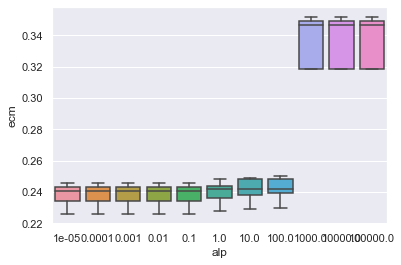

In [44]:
# Box plot para regularización LASSO

import seaborn as sns
sns.set()
ss = sns.boxplot(data=reg_lasso[1], x="alp", y="ecm")

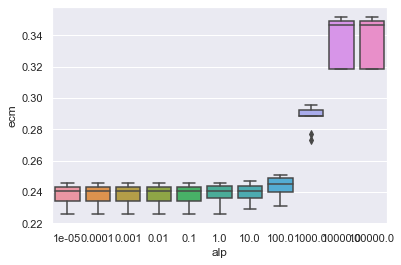

In [45]:
# Box plot para regularización Ridge

sns.set()
ss = sns.boxplot(data=reg_ridge[1], x="alp", y="ecm")

### 6. En el caso del valor óptimo de λ para LASSO encontrado en el inciso anterior, ¿qué variables fueron descartadas? ¿Son las que hubieran esperado? ¿Tiene relación con lo que respondió en el inciso 1 de la Parte I?

En este caso, LASSO no elimina ningún coeficiente, aunque esto tiene sentido si pensamos que nos está eligiendo el menor valor posible de λ, 0.00001. Esto significaría que el parámetro C, la inversa de λ, es un valor muy alto, lo que implica una regularización más suave. Los coeficientes, como se muestra en el código de la celda inferior, tienen valores distintos a cero incluso bajo esta especificación, correspondiéndose estos con las variables que identificamos a priori en el inciso 1 de la parte I como relevantes para explicar la pobreza.

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
lasso_best = Lasso(alpha=0.00001)
lasso_best.fit(x_train, y_train)
print(list(zip(lasso_best.coef_, x)))

[(0.0, 'const'), (-0.07791502576654773, 'IV1'), (0.03553496519076176, 'IV3'), (0.10828034936582294, 'IV6'), (0.05376830587250515, 'IV7'), (-0.28902013068611654, 'IV8'), (-0.11591115231350718, 'IV9'), (-0.0276535584491332, 'IV12_1'), (-0.09218188665565955, 'IV12_3'), (-0.0036293040033668375, 'II7'), (0.06867994346812321, 'II8'), (0.016189361077526526, 'V1'), (-0.02098490679121852, 'V2'), (-0.3686961637123647, 'V5'), (-0.07460485720364407, 'CH09'), (-0.005149230461996298, 'CH10'), (-0.033413453058413575, 'CH11'), (-0.0028490352207195886, 'CH12'), (-0.003937466007443816, 'CH06')]


### 7. Elijan alguno de los modelos de regresión logistica donde haya probado distintos parametros de regularización y comente: ¿Qué metodo de regularización funcionó mejor Ridge o LASSO? Comente mencionando el error cuadrático medio (ECM).

En base a nuestras respuestas previas, podemos observar que con el valor de λ elegido por el algoritmo, el ECM se minimiza en el mismo punto para ambas especificaciones (ya que no se elimina ningún coeficiente con LASSO), por lo que podemos inferir que ambos métodos de regularización tienen el mismo rendimiento bajo las regresiones realizadas. 

Más allá que parezca raro que suceda esto, en el ejemplo del ejercicio 2 pudimos ver que el algoritmo eligió el último λ que le dimos para iterar, por lo que no tenemos razones para pensar que la función está fallando en este caso (por ejemplo, eligiendo el primer valor que se le da). 

In [47]:
modelos = ["Logit"]
parametros = {"k_range": range(3,5), "penalty": ["l1", "l2"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} # l1enalty de Lasso, la l2 es Ridge. 

lasso_7 = evalua_multiples_metodos(modelos,x,y,parametros)

lasso_7[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,Logit,,,l1,0.00001,0.782377,0.217623,0.51925,0.696911,476,36,127,110
1,Logit,,,l2,0.00001,0.782377,0.217623,0.51925,0.696911,476,36,127,110


### 8. ¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros? Justifiquen detalladamente utilizando las medidas de precisión que conoce.

En base a las tablas presentadas en los incisos anteriores, si nuestra preocupación es minimizar el ECM y mejor la precisión, el mejor método de los analizados es Logit con un λ = 0.00001, ya que el ECM en este caso (bajo ambas especificaciones de Logit) es de 0.217623, contra un 0.220294 de LDA (con 1 componente) y 0.272363 de KNN (con 5 vecinos). 

Sin embargo, si la idea es identificar hogares pobres para incluirlos en alguna política pública de inclusión, nuestro objetivo pasaría a identificar la mayor cantidad posible de verdaderos positivos, ya que esto nos daría un mayor alcance dentro de la población objetivo. Si tenemos en cuenta esto, LDA podría ser un método superior, ya que identifica 112 verdaderos positivos al observar la matriz de confusión, contra 110 de Logit. La cantidad de verdaderos negativos solo difere en 4 a favor de Logit, por lo que algún análisis costo-beneficio no pareciera ir en contra de la mejor identificación de LDA. 

A su vez, el área debajo de la curva ROC de LDA es de 0.697224, contra un 0.696911 de Logit, por lo que marginalmente podemos ver que el método LDA posee una mejor precisión en la clasificación. Por esta razón y por lo expuesto en el párrafo anterior, decidimos que el mejor método resulta ser LDA.

### 9. Con el método que seleccionó, predigan qué personas son pobres dentro de la base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

lda_final = LinearDiscriminantAnalysis(n_components=1)
lda_final_fit = lda_final.fit(x_train, y_train)

y_pred = lda_final_fit.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, y_pred)
y_pred = np.where(y_pred <= 0.5, 0, y_pred)

count = np.count_nonzero(y_pred == 1)

print("En base al modelo",lda_final,", la cantidad predicha de hogares pobres para la submuestra es de", count, "personas.")

proporcion = np.count_nonzero(y_pred == 1)/(len(y_pred))
proporcion = proporcion*100
print("La proporción de hogares pobres en la submuestra es del %.2f" % proporcion,"%.")

En base al modelo LinearDiscriminantAnalysis(n_components=1) , la cantidad predicha de hogares pobres para la submuestra es de 152 personas.
La proporción de hogares pobres en la submuestra es del 20.29 %.


Como puede verse en los print de la celda superior, el método LDA con 1 componente identifica a 152 hogares pobres en la submuestra, correspondiéndose esto con un 20,29% de la misma. Esta es una mejora sustancial contra el ejercicio 7 de la parte I, donde solo se predecía que un 5,15% de la submuestra estaba compuesta por hogares pobres. 